Loading data...
Training data: 4000 tweets, Labels distribution: {0: 2712, 1: 1288}
Test data: 1000 tweets
Preprocessing and extracting features...
Preprocessing and extracting features...
Creating TF-IDF features (max_features=3000)...
Created 3000 TF-IDF features
Final feature dimensions: 3029 features
Splitting training data for validation...
Comparing resampling strategies...

Evaluating smote...
SMOTE - F1 Score: 0.6447
Resampled class distribution: [2170 2170]

Evaluating adasyn...
ADASYN - F1 Score: 0.6608
Resampled class distribution: [2170 2073]

Evaluating borderline_smote...
BORDERLINE_SMOTE - F1 Score: 0.6486
Resampled class distribution: [2170 2170]

Evaluating smote_tomek...
SMOTE_TOMEK - F1 Score: 0.6343
Resampled class distribution: [2104 2104]

Evaluating smote_enn...
SMOTE_ENN - F1 Score: 0.5564
Resampled class distribution: [ 579 1599]

Evaluating hybrid...
HYBRID - F1 Score: 0.6399
Resampled class distribution: [1471 1176]

Best resampling strategy: ADASYN with F1 s

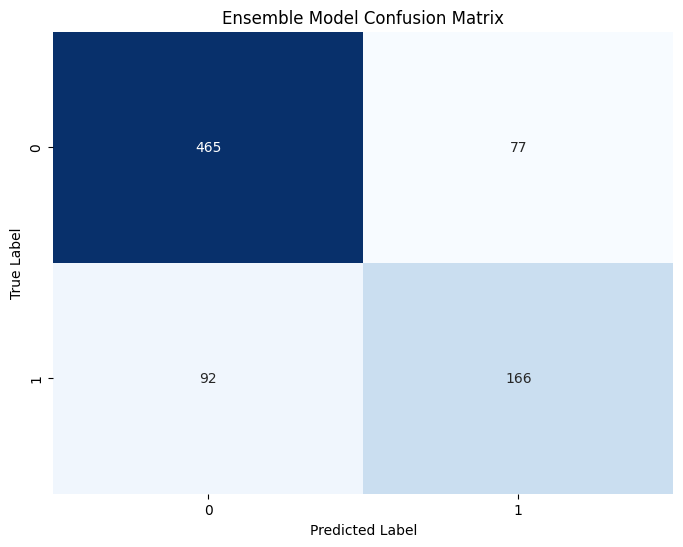

In [1]:

import pandas as pd
import numpy as np
import re
import warnings
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

def load_and_prepare_data(train_tweets_path, train_labels_path, test_tweets_path):
    """Load and merge the training and test datasets"""
    print("Loading data...")
    train_tweets = pd.read_csv(train_tweets_path)
    train_labels = pd.read_csv(train_labels_path)
    test_tweets = pd.read_csv(test_tweets_path)
    
    train_data = pd.merge(train_tweets, train_labels, on='TweetID')
    print(f"Training data: {train_data.shape[0]} tweets, Labels distribution: {train_data['Label'].value_counts().to_dict()}")
    print(f"Test data: {test_tweets.shape[0]} tweets")
    
    return train_data, test_tweets

def clean_text(text):
    """Enhanced text cleaning with better handling of mentions, URLs, and special characters"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' url ', text)
    text = re.sub(r'@\w+', ' user ', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^\w\s\']', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    return text

def extract_features(df, is_training=True):
    """Extract comprehensive features from tweets"""
    print("Preprocessing and extracting features...")
    df = df.copy()
    
    df['CleanedTweet'] = df['Tweet'].apply(clean_text)
    
    df['TweetLength'] = df['Tweet'].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)
    df['WordCount'] = df['CleanedTweet'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    
    activity_patterns = {
        'activity_words': r'\b(walk|run|jog|swim|bike|hike|climb|danc|workout|exercise|train|ski|skate|play|lift|gym|yoga|push|pull|squat)',
        'activity_ing': r'\b(walking|running|jogging|swimming|biking|hiking|climbing|dancing|working out|exercising|training|skiing|skating)',
        'activity_past': r'\b(walked|ran|jogged|swam|biked|hiked|climbed|danced|worked out|exercised|trained|skied|skated)'
    }
    
    context_patterns = {
        'first_person': r'\b(i|me|my|mine|we|us|our|ours)\b',
        'past_time': r'\b(yesterday|last night|earlier today|this morning|previously|ago|before|earlier|past)\b',
        'future_time': r'\b(tomorrow|planning to|will|going to|about to|later|soon|next|upcoming)\b',
        'effort_words': r'\b(tired|exhausted|sore|sweat|pump|burn|breathe|pain|gain|muscles|ache|hurt|cardio|stretch|strain)\b',
        'watching': r'\b(watch|watching|saw|see|seeing|view|viewing|observe|spectating|cheer|cheering)\b',
        'location': r'\b(gym|track|pool|court|field|path|trail|park|home|house|studio|class)\b',
        'equipment': r'\b(weights|machine|treadmill|bike|elliptical|rower|mat|bar|bench|ball|racket)\b',
        'negative': r'\b(don\'t|didn\'t|not|no|never|won\'t|can\'t|couldn\'t)\b'
    }
    
    self_activity_patterns = {
        'self_activity': r'\bi\s+(\w+\s+){0,3}(walk|run|jog|swim|bike|hike|climb|danc|workout|exercise|train)',
        'self_activity_past': r'\bi\s+(\w+\s+){0,3}(walked|ran|jogged|swam|biked|hiked|climbed|danced|worked out)'
    }
    
    for name, pattern in {**activity_patterns, **context_patterns, **self_activity_patterns}.items():
        df[f'has_{name}'] = df['CleanedTweet'].apply(lambda x: 1 if re.search(pattern, x, re.IGNORECASE) else 0)
    
    df['fp_activity_distance'] = df.apply(
        lambda x: distance_between_patterns(
            x['CleanedTweet'], 
            context_patterns['first_person'], 
            activity_patterns['activity_words']
        ), axis=1
    )
    
    df['sin_time'] = np.sin(2 * np.pi * df['TimeOfDay'] / 24)
    df['cos_time'] = np.cos(2 * np.pi * df['TimeOfDay'] / 24)
    
    time_periods = {
        'morning': ((5 <= df['TimeOfDay']) & (df['TimeOfDay'] < 10)),
        'midday': ((10 <= df['TimeOfDay']) & (df['TimeOfDay'] < 15)),
        'evening': ((15 <= df['TimeOfDay']) & (df['TimeOfDay'] < 21)),
        'night': ((21 <= df['TimeOfDay']) | (df['TimeOfDay'] < 5))
    }
    
    for period, mask in time_periods.items():
        df[f'{period}_time'] = mask.astype(int)
    
    df['fp_with_activity'] = df['has_first_person'] * df['has_activity_words']
    df['fp_with_past_activity'] = df['has_first_person'] * df['has_activity_past']
    df['watching_not_doing'] = df['has_watching'] * df['has_activity_words']
    df['negative_activity'] = df['has_negative'] * df['has_activity_words']
    
    for period in time_periods.keys():
        df[f'{period}_self_activity'] = df[f'{period}_time'] * df['has_self_activity']
    
    return df

def distance_between_patterns(text, pattern1, pattern2, max_distance=10):
    """Calculate the minimum word distance between two patterns in text"""
    if not isinstance(text, str):
        return max_distance
    
    words = text.lower().split()
    matches1 = [i for i, word in enumerate(words) if re.search(pattern1, word)]
    matches2 = [i for i, word in enumerate(words) if re.search(pattern2, word)]
    
    if not matches1 or not matches2:
        return max_distance
    
    min_distance = min(abs(i - j) for i in matches1 for j in matches2)
    return min(min_distance, max_distance)

def create_tfidf_features(train_data, test_data, max_features=3000):
    """Create TF-IDF features with improved parameters"""
    print(f"Creating TF-IDF features (max_features={max_features})...")
    
    tfidf = TfidfVectorizer(
        max_features=max_features,
        min_df=2,
        max_df=0.85, 
        ngram_range=(1, 4),  
        sublinear_tf=True,   
        use_idf=True,
        norm='l2'
    )
    
    X_train_tfidf = tfidf.fit_transform(train_data['CleanedTweet'])
    X_test_tfidf = tfidf.transform(test_data['CleanedTweet'])
    
    print(f"Created {X_train_tfidf.shape[1]} TF-IDF features")
    return X_train_tfidf, X_test_tfidf, tfidf

def prepare_model_features(train_data, test_data):
    """Prepare and combine all features for modeling"""
    feature_cols = [col for col in train_data.columns if col.startswith('has_') or 
                   col.endswith('_time') or col.endswith('_activity') or 
                   col in ['TweetLength', 'WordCount', 'fp_activity_distance', 
                           'sin_time', 'cos_time']]
    
    X_train_tfidf, X_test_tfidf, tfidf = create_tfidf_features(train_data, test_data)
    
    X_train_features = train_data[feature_cols].values
    X_test_features = test_data[feature_cols].values
    
    scaler = StandardScaler()
    X_train_features_scaled = scaler.fit_transform(X_train_features)
    X_test_features_scaled = scaler.transform(X_test_features)
    
    X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train_features_scaled))
    X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test_features_scaled))
    
    print(f"Final feature dimensions: {X_train_combined.shape[1]} features")
    
    return X_train_combined, X_test_combined, feature_cols

def compare_resampling_strategies(X_train, y_train, X_val, y_val):
    """Compare different resampling strategies and select the best one"""
    print("Comparing resampling strategies...")
    
    strategies = {
        'smote': SMOTE(random_state=42),
        'adasyn': ADASYN(random_state=42),
        'borderline_smote': BorderlineSMOTE(random_state=42),
        'smote_tomek': SMOTETomek(random_state=42),
        'smote_enn': SMOTEENN(random_state=42),
        'hybrid': [
        ('under', RandomUnderSampler(sampling_strategy=0.7, random_state=42)),
        ('over', SMOTE(sampling_strategy=0.8, random_state=42))
]

    }
    
    model = LogisticRegression(C=1.5, class_weight='balanced', max_iter=1000, random_state=42)
    
    results = {}
    for name, strategy in strategies.items():
        print(f"\nEvaluating {name}...")
        
        if name == 'hybrid':
            X_resampled, y_resampled = X_train.copy(), y_train.copy()
            for step_name, sampler in strategy:
                X_resampled, y_resampled = sampler.fit_resample(X_resampled, y_resampled)
        else:
            X_resampled, y_resampled = strategy.fit_resample(X_train, y_train)
        
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        
        results[name] = {
            'f1': f1,
            'strategy': strategy,
            'class_distribution': np.bincount(y_resampled)
        }
        
        print(f"{name.upper()} - F1 Score: {f1:.4f}")
        print(f"Resampled class distribution: {np.bincount(y_resampled)}")
    
    best_strategy = max(results.items(), key=lambda x: x[1]['f1'])
    print(f"\nBest resampling strategy: {best_strategy[0].upper()} with F1 score: {best_strategy[1]['f1']:.4f}")
    
    return best_strategy[1]['strategy'], results

def train_evaluate_models(X_train, y_train, X_val, y_val):
    """Train multiple models and evaluate their performance"""
    print("Training multiple models...")
    
    models = {
        'lr': LogisticRegression(
            C=1.5,  
            solver='saga',  
            class_weight='balanced', 
            max_iter=2000, 
            random_state=42
        ),
        
        'svm': SVC(C=10, gamma='scale', probability=True, class_weight='balanced', 
                  kernel='rbf', random_state=42),
        
        'gb': GradientBoostingClassifier(
            n_estimators=300, 
            learning_rate=0.05, 
            max_depth=6, 
            min_samples_split=10,
            subsample=0.8,  
            random_state=42
        ),
        
        'rf': RandomForestClassifier(
            n_estimators=500,  
            max_depth=20,      
            min_samples_split=2,
            min_samples_leaf=1,  
            class_weight='balanced_subsample',  
            max_features='sqrt',
            bootstrap=True,
            random_state=42
        ),
        
        'xgb': XGBClassifier(
            n_estimators=300, 
            max_depth=6, 
            learning_rate=0.05, 
            subsample=0.8, 
            colsample_bytree=0.8, 
            scale_pos_weight=2.0, 
            random_state=42
        )
    }
    
    performance = {}
    for name, model in models.items():
        print(f"\nTraining {name.upper()}...")
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        performance[name] = f1
        
        print(f"{name.upper()} - F1 Score: {f1:.4f}")
        print(classification_report(y_val, y_pred))
    
    return models, performance

def create_ensemble(models, performance):
    """Create weighted ensemble from trained models"""
    print("\nCreating weighted ensemble model...")
    
    estimators = [(name, model) for name, model in models.items()]
    
    weights = [performance[name]**2 for name, _ in models.items()]
    
    print(f"Model weights: {dict(zip([name for name, _ in models.items()], weights))}")
    
    ensemble = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
    return ensemble

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """Plot a styled confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.savefig('confusion_matrix.png')
    print("Confusion matrix saved to 'confusion_matrix.png'")

def main():
    """Main execution function with improved resampling strategies"""
    train_data, test_tweets = load_and_prepare_data(
        '/kaggle/input/files/WN25_PA_training_tweets.txt',
        '/kaggle/input/files/WN25_PA_training_labels.txt',
        '/kaggle/input/files/WN25_PA_test_tweets.txt'
    )
    
    train_data = extract_features(train_data)
    test_tweets = extract_features(test_tweets, is_training=False)
    
    X_combined_train, X_combined_test, feature_cols = prepare_model_features(train_data, test_tweets)
    
    print("Splitting training data for validation...")
    X_train, X_val, y_train, y_val = train_test_split(
        X_combined_train, train_data['Label'], 
        test_size=0.2, random_state=42, stratify=train_data['Label']
    )
    
    best_strategy, strategy_results = compare_resampling_strategies(X_train, y_train, X_val, y_val)
    
    print(f"\nApplying best resampling strategy...")
    if isinstance(best_strategy, list):
        X_resampled, y_resampled = X_train.copy(), y_train.copy()
        for step_name, sampler in best_strategy:
            X_resampled, y_resampled = sampler.fit_resample(X_resampled, y_resampled)
    else:
        X_resampled, y_resampled = best_strategy.fit_resample(X_train, y_train)
        
    print(f"Original class distribution: {np.bincount(y_train)}")
    print(f"Resampled class distribution: {np.bincount(y_resampled)}")
    
    models, performance = train_evaluate_models(X_resampled, y_resampled, X_val, y_val)
    
    ensemble = create_ensemble(models, performance)
    ensemble.fit(X_resampled, y_resampled)
    
    y_val_pred = ensemble.predict(X_val)
    ensemble_f1 = f1_score(y_val, y_val_pred)
    print(f"\nEnsemble model validation F1-score: {ensemble_f1:.4f}")
    print(classification_report(y_val, y_val_pred))
    
    plot_confusion_matrix(y_val, y_val_pred, "Ensemble Model Confusion Matrix")
    
    print("\nTraining final model on all training data...")
    if isinstance(best_strategy, list):
        X_full_resampled, y_full_resampled = X_combined_train.copy(), train_data['Label'].copy()
        for step_name, sampler in best_strategy:
            X_full_resampled, y_full_resampled = sampler.fit_resample(X_full_resampled, y_full_resampled)
    else:
        X_full_resampled, y_full_resampled = best_strategy.fit_resample(X_combined_train, train_data['Label'])
    
    print(f"Original full data class distribution: {np.bincount(train_data['Label'])}")
    print(f"Resampled full data class distribution: {np.bincount(y_full_resampled)}")
    
    ensemble.fit(X_full_resampled, y_full_resampled)
    
    print("Making predictions on test data...")
    test_predictions = ensemble.predict(X_combined_test)
    
    submission = pd.DataFrame({
        'TweetID': test_tweets['TweetID'],
        'Label': test_predictions
    })
    
    submission.to_csv('/kaggle/working/submission.csv', index=False)
    print("Submission saved to '/kaggle/working/submission.csv'")

if __name__ == "__main__":
    main()
